In [1]:
import warnings
from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import loguniform
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_circles
from sklearn.exceptions import ConvergenceWarning
from tqdm.notebook import tqdm
import mlflow

warnings.simplefilter('ignore', category=ConvergenceWarning)

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Случайный поиск

In [4]:
MAX_ITERATION = 100
MIN_ESTIMATORS = 1
MAX_ESTIMATORS = 101

  0%|          | 0/100 [00:00<?, ?it/s]

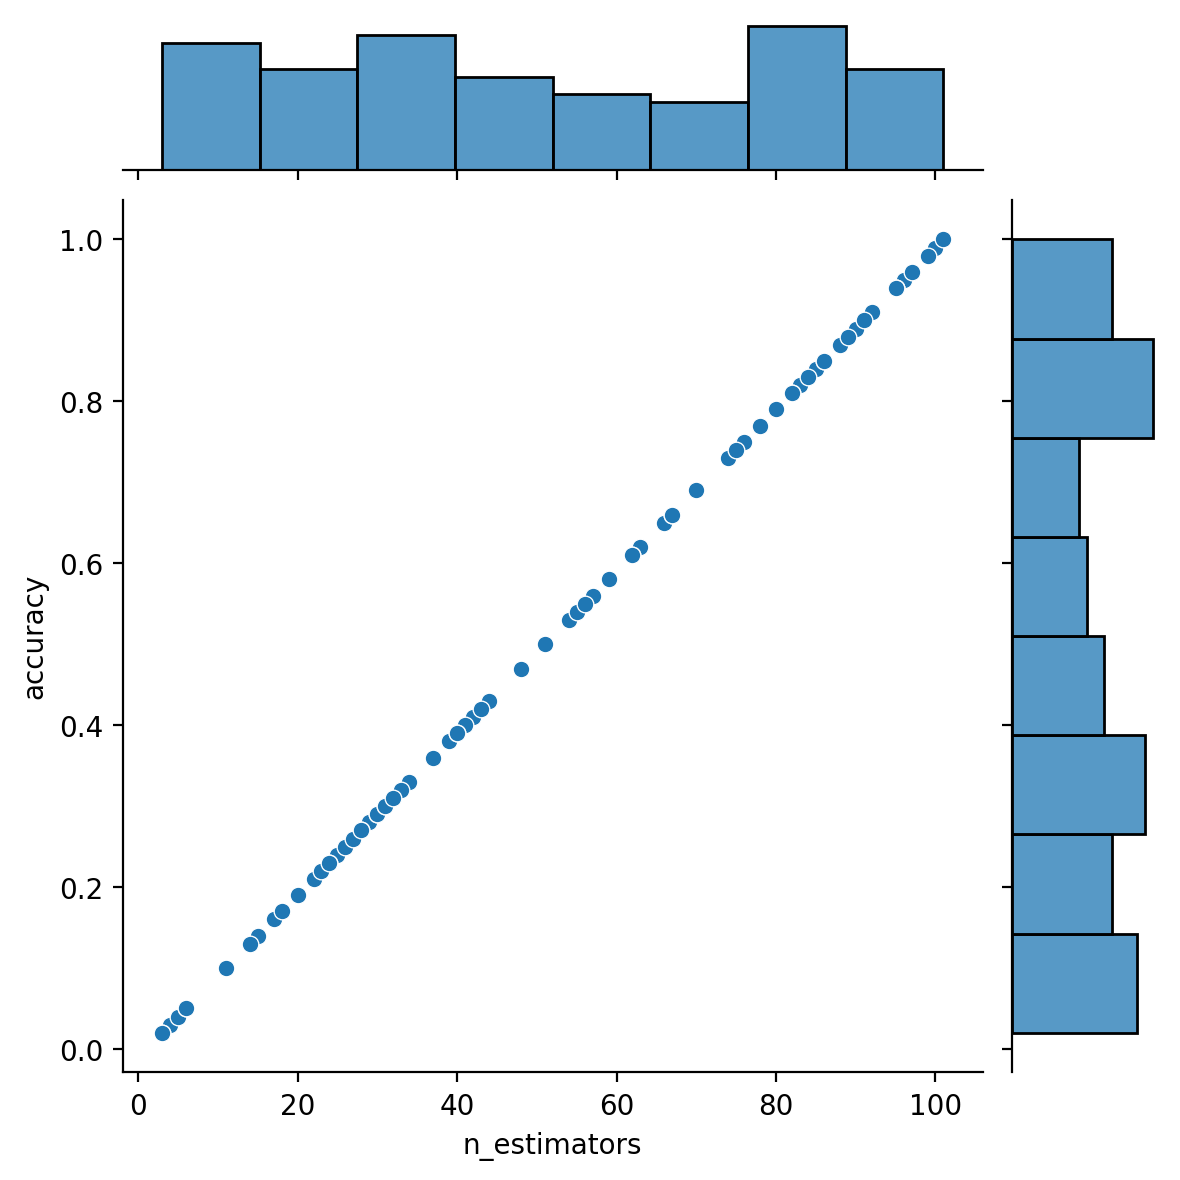

In [44]:
options = np.arange(2, 102, dtype=int)

history = []

for _ in tqdm(range(MAX_ITERATION), total=MAX_ITERATION):
  n_estimators = np.random.choice(options)

  # Считаем, что точность прямопропорциональна n_estimators
  # и равна MinMaxScaler от всех вариантов
  accuracy = (n_estimators-MIN_ESTIMATORS)/(MAX_ESTIMATORS-MIN_ESTIMATORS)
  history.append({
    'accuracy': accuracy,
    'n_estimators': n_estimators
  })

sns.jointplot(data=pd.DataFrame(history), x='n_estimators', y='accuracy')

## Hyperopt

### Определяем пространство поиска

In [48]:
search_space = {
  'n_estimators' : hp.choice(label='n_estimators', options=np.arange(MIN_ESTIMATORS, MAX_ESTIMATORS, dtype=int)),
}

### Определяем функцию, которую HyperOpt будет оптимизировать

In [49]:
def objective(params):   
  n_estimators = params['n_estimators']
  accuracy = (n_estimators-MIN_ESTIMATORS)/(MAX_ESTIMATORS-MIN_ESTIMATORS)    
  return {'loss': -accuracy, 'params': params, 'status': STATUS_OK}

### Погнали!

100%|██████████| 100/100 [00:00<00:00, 256.90trial/s, best loss: -0.99]


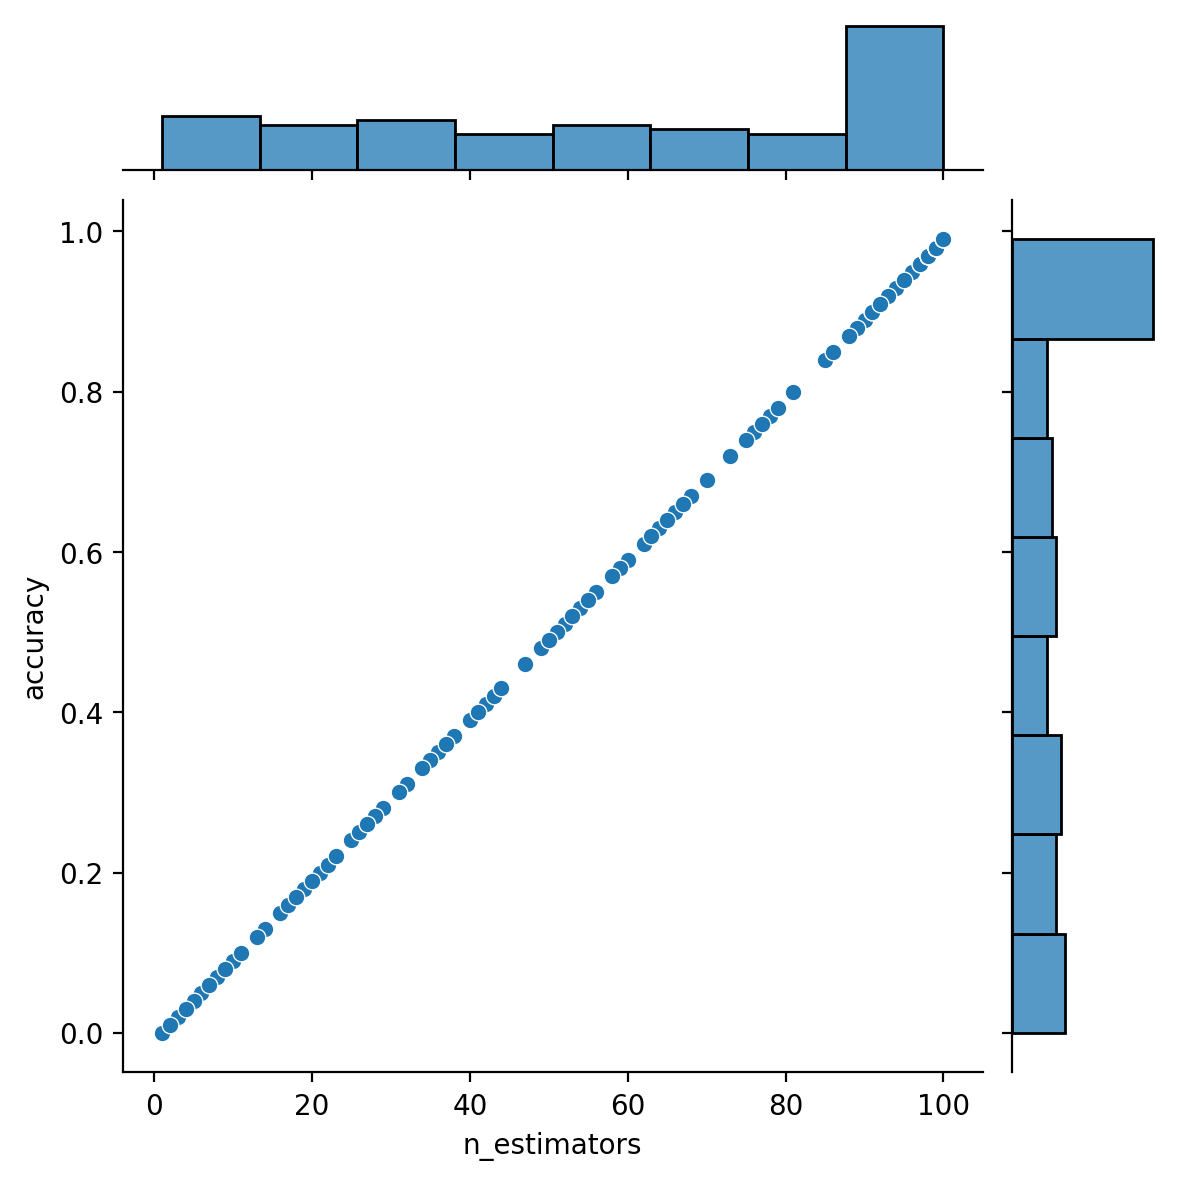

In [63]:
trials = Trials()

best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

results = pd.DataFrame([
  {'accuracy': -x['loss'], 'n_estimators': x['params']['n_estimators']} for x in trials.results
])

sns.jointplot(data=results, x='n_estimators', y='accuracy')

## Еще пример HyperOpt
### Генерируем данные

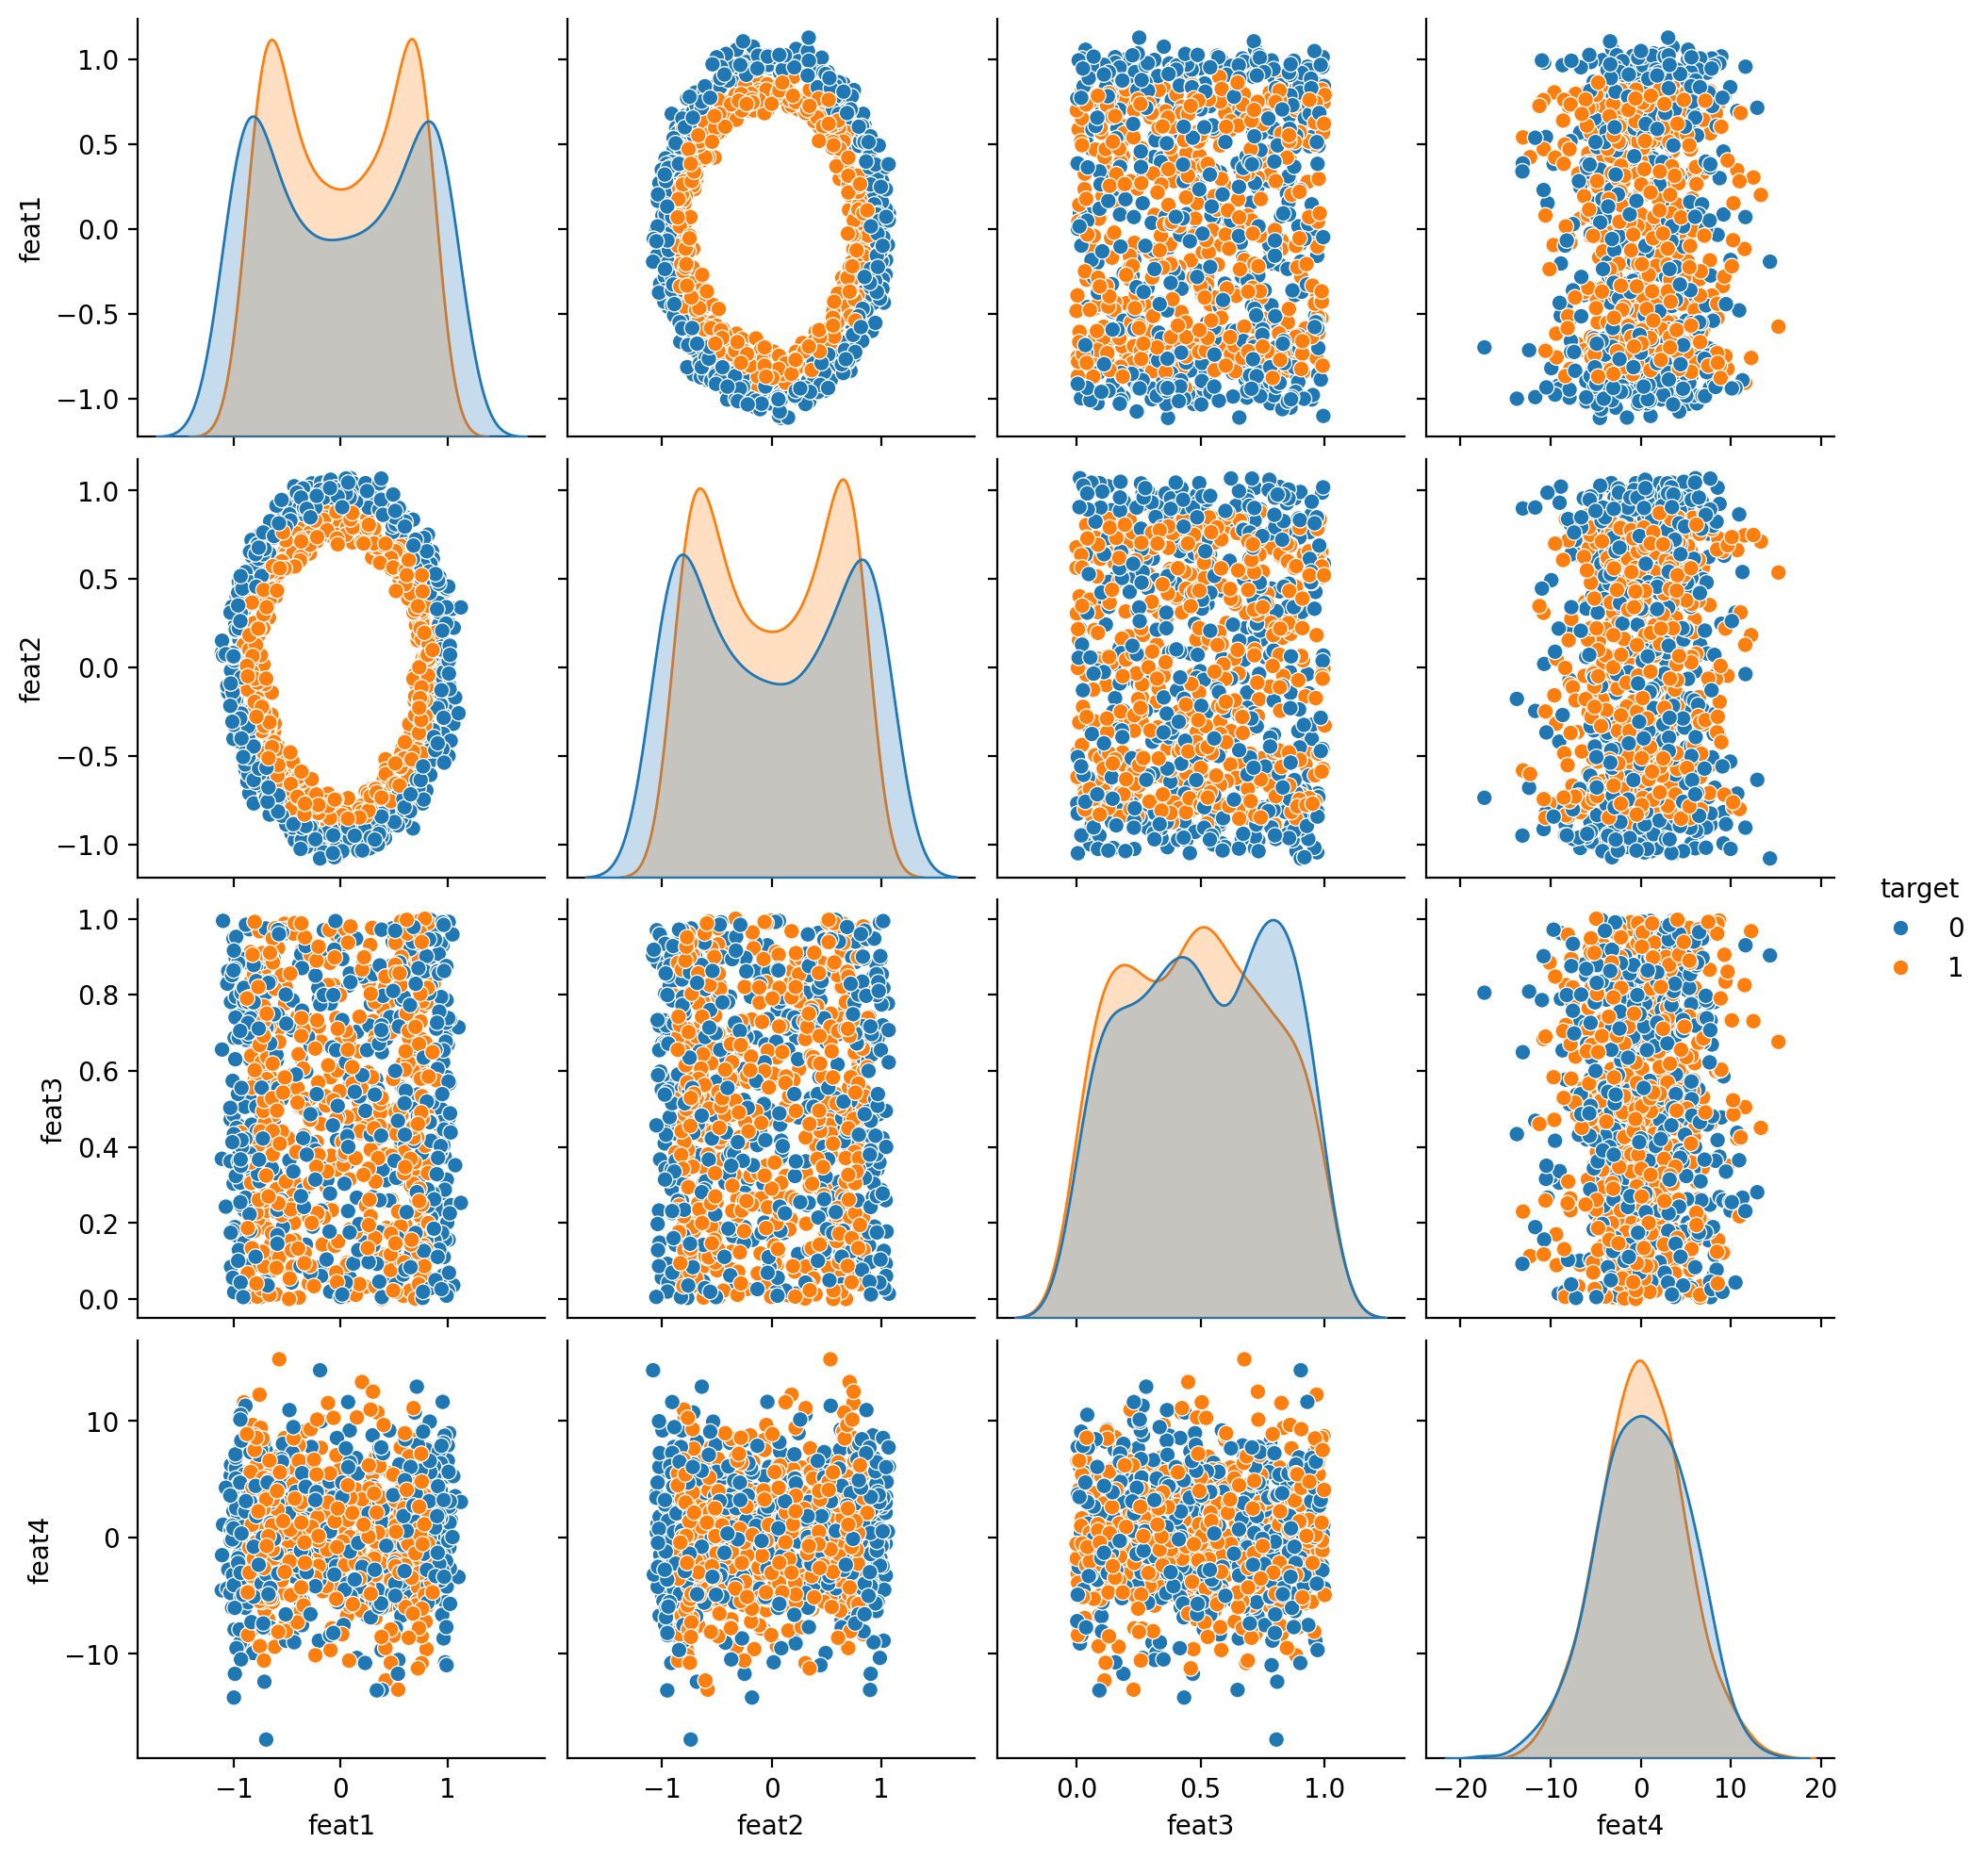

In [2]:
CX, y = make_circles(n_samples=1_000, random_state=0, noise=0.05)

df = pd.DataFrame({
    'feat1': CX[:, 0],
    'feat2': CX[:, 1],
    'feat3': np.random.rand(CX.shape[0]),
    'feat4': np.random.normal(0, 5, CX.shape[0]),
    'target': y
})

sns.pairplot(df, hue='target')

### Моделируем

In [5]:
search_space = hp.choice(
  label='model',
  options=[
    {
      'classifier': 'lr',
      'C': hp.lognormal(label='LR_C', mu=0, sigma=1.0),
      'solver': hp.choice(label='solver', options=['liblinear', 'lbfgs'])
    },
    {
      'classifier': 'dtc',
      'criterion': hp.choice(label='dtr_criterion', options=['gini', 'entropy', 'log_loss']),
      'max_depth': hp.randint(label='max_depth', low=2, high=50)
    },
    {
      'classifier': 'svm',
      'C': hp.lognormal(label='SVM_C', mu=0, sigma=1.0),
      'kernel': hp.choice(label='kernel', options=['linear', 'rbf'])
    },
    {
      'classifier': 'rfc',
      'n_estimators': hp.choice(label='n_estimators', options=np.arange(MIN_ESTIMATORS, MAX_ESTIMATORS, dtype=int)),
      'criterion': hp.choice(label='rfc_criterion', options=['gini', 'entropy', 'log_loss'])
    }
  ]
)

In [6]:
def objective(params, X_train, y_train): 

  with mlflow.start_run():

    mlflow.log_params(params)

    classifier = params['classifier']
    del params['classifier']

    match classifier:
      case 'lr':
        model = LogisticRegression(**params)
      case 'dtc':
        model = DecisionTreeClassifier(**params)
      case 'svm':
        model = SVC(**params)
      case 'rfc':
        model = RandomForestClassifier(**params)
      case _:
        return 0
    
    accuracy = cross_val_score(model, X_train, y_train, cv=3).mean()

    mlflow.log_metric('accuracy', accuracy)
   
  return {'loss': -accuracy, 'status': STATUS_OK}

In [7]:
X = StandardScaler().fit_transform(df[['feat1', 'feat2', 'feat3', 'feat4']])
y = df['target']

trials = Trials()

best = fmin(
    fn=partial(objective, X_train=X, y_train=y),
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

100%|██████████| 100/100 [00:05<00:00, 19.47trial/s, best loss: -0.9549969130807455]


In [8]:
best

{'SVM_C': 69.97973949250755, 'kernel': 1, 'model': 2}